# First look at halo models available in CCL, comparison to CLMM (based on cluster-toolkit)


In [1]:
import pyccl
import sys
sys.path.append('./support')
import clmm
import clmm.modeling as m
import numpy as np
import matplotlib.pyplot as plt

In [2]:
cosmo = pyccl.Cosmology(Omega_c=0.26, Omega_b=0.04,
                            h=0.7, n_s=0.96, sigma8=0.8,
                            transfer_function='bbks')

# Need to convert to dictionary for CLMM
cosmo_dict = {'Omega_c': cosmo['Omega_c'], 'Omega_b': cosmo['Omega_b'],
                'h': cosmo['h'], 'H0': cosmo['H0']}

## 1. NFW halo in z=0
What we'll see below:
- If units from CCL properly understood, then agreement between CCL and CLMM/cluster-toolkit.
- Relative difference at the 1.e-4 level, which seems a bit much given that all is analytical. Physical constant definitions?


In [3]:
# Configuration
mass_Delta = 200
cluster_concentration = 4
cluster_mass = 1.e15 #Msun
z_cl = 0.
r = np.logspace(-2,2,30) #Mpc

#### 1.1 First, looking at the 3D density

##### - CCL
There are two ways to get that quantity in CCL, one being deprecated. Going to use both.

In [4]:
a = 1./(1+z_cl)
cluster_mass_ccl = cluster_mass #Msun
r_ccl = r

# Obsolete function -  not sure what mass definition it used (matter or critical)
rho_nfw_ccl_old0 = pyccl.nfw_profile_3d(cosmo, cluster_concentration, 
                                    cluster_mass_ccl, mass_Delta, a, r_ccl)# Msun pc-3

/pbs/throng/lsst/users/ccombet/CCL/pyccl/pyutils.py:403: CCLWarning: The function nfw_profile_3d is deprecated. Use HaloProfileNFW instead.
  warnings.warn(s, CCLWarning)


Following the deprecation warning, use HaloProfileNFW below

In [5]:
# Latest approach, using HaloProfileNFW
# CLMM defined the spherical overdensity mass w.r.t to the matter density, so make the same 
# choice for mass_def in CCL
mass_def = pyccl.halos.massdef.MassDef(200, 'matter')

c_M_rel = pyccl.halos.concentration.ConcentrationConstant(c=cluster_concentration, 
                                                          mdef=mass_def)
nfw_obj = pyccl.halos.profiles.HaloProfileNFW(c_M_rel, projected_analytic=True, 
                                              cumul2d_analytic=True, truncated=False)
rho_nfw_ccl_new0 = nfw_obj.real(cosmo, r_ccl, cluster_mass_ccl, a, mass_def=mass_def) # Msun pc-3


##### - CLMM
CLMM modeling module takes radius in Mpc/h and mass in Msun/h. So need to modify to match the CCL configuration above

In [7]:
# new radius and mass definition
r_clmm = r*cosmo['h'] #Mpc/h
cluster_mass_clmm = cluster_mass*cosmo['h']#Msun/h

# CLMM 3d density - units = h2 Msun pc-3
rho_nfw_clmm0 = m.get_3d_density(r_clmm, mdelta=cluster_mass_clmm, 
                                cdelta=cluster_concentration, delta_mdef=mass_Delta, 
                                z_cl=z_cl, cosmo=cosmo_dict,halo_profile_model='nfw')

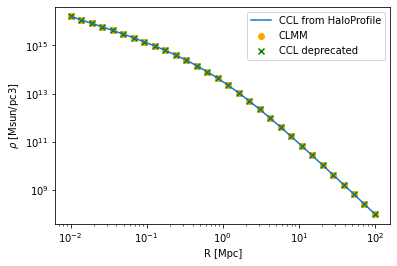

In [8]:
# CLMM result multiplied by h2 to match CCL units
plt.loglog(r_ccl,rho_nfw_ccl_old0, label='CCL from HaloProfile')
plt.scatter(r_ccl,rho_nfw_clmm0*cosmo['h']*cosmo['h'], label='CLMM', marker='o', color='orange')
plt.scatter(r_ccl,rho_nfw_ccl_new0, marker='x', color='green', label='CCL deprecated')
plt.xlabel('R [Mpc]')
plt.ylabel(r'$\rho$ [Msun/pc3]')
plt.legend()

Looking at the relative difference, variation at 1.e-4 level exist. A bit much given that it's all analytical. Where does the small difference comes from ? physical constant definitions?

In [9]:
rho_nfw_ccl_new0 / (rho_nfw_clmm0*cosmo['h']*cosmo['h']) - 1 

array([1.68835167e-04, 1.68030191e-04, 1.66936729e-04, 1.65457507e-04,
       1.63467547e-04, 1.60810477e-04, 1.57297902e-04, 1.52715171e-04,
       1.46837966e-04, 1.39464311e-04, 1.30463832e-04, 1.19838783e-04,
       1.07779836e-04, 9.46896579e-05, 8.11494680e-05, 6.78251752e-05,
       5.53415471e-05, 4.41721554e-05, 3.45831457e-05, 2.66386207e-05,
       2.02482957e-05, 1.52292534e-05, 1.13605676e-05, 8.42152133e-06,
       6.21323565e-06, 4.56773896e-06, 3.34917555e-06, 2.45090922e-06,
       1.79098931e-06, 1.30737821e-06])

#### 1.2 Projected surface density Sigma for NFW

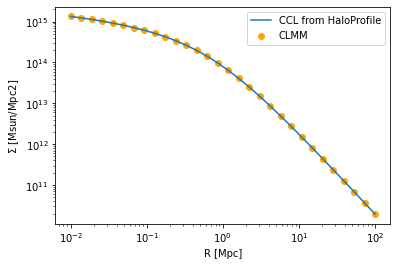

In [10]:
Sigma_nfw_ccl0 = nfw_obj.projected(cosmo, r_ccl, cluster_mass_ccl, a, mass_def) # M_sun/Mpc2
Sigma_nfw_clmm0 = m.predict_surface_density(r_clmm, cluster_mass_clmm, 
                                           cluster_concentration, z_cl, cosmo=cosmo_dict, 
                                           delta_mdef=mass_Delta, 
                                           halo_profile_model='nfw') # h M_sun/pc2
plt.loglog(r_ccl,Sigma_nfw_ccl0, label='CCL from HaloProfile')

plt.scatter(r_ccl,Sigma_nfw_clmm0*cosmo['h']*1.e12, label='CLMM', marker='o', color='orange')
plt.xlabel('R [Mpc]')
plt.ylabel(r'$\Sigma$ [Msun/Mpc2]')
plt.legend()

In [11]:
Sigma_nfw_ccl0 / (Sigma_nfw_clmm0*cosmo['h']*1.e12) - 1 

array([1.49891481e-04, 1.48123563e-04, 1.46054470e-04, 1.43612973e-04,
       1.40710437e-04, 1.37238853e-04, 1.33071097e-04, 1.28065707e-04,
       1.22079319e-04, 1.14989940e-04, 1.06732255e-04, 9.73408059e-05,
       8.69885394e-05, 7.60010733e-05, 6.48289043e-05, 5.39757657e-05,
       4.39048211e-05, 3.49582292e-05, 2.73178770e-05, 2.10122963e-05,
       1.59546726e-05, 1.19905985e-05, 8.93972092e-06, 6.62453264e-06,
       4.88639569e-06, 3.59199191e-06, 2.63384001e-06, 1.92775747e-06,
       1.40914539e-06, 1.02915237e-06])

#### 1.3 Cumulative Sigma within R - Sigma(<R)

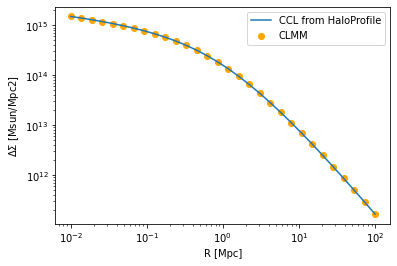

In [12]:
SigmaCumul_nfw_ccl0 = nfw_obj.cumul2d(cosmo, r_ccl, cluster_mass_ccl, a, mass_def) # M_sun/Mpc2

# In CLMM, the function predict_excess_surface_density returns DeltaSigma(R) = Sigma(<R) - Sigma(R), so Sigma(<R) = DeltaSigma(R) + Sigma(R). 
# This is what is used below.
SigmaCumul_nfw_clmm0 = m.predict_excess_surface_density(r_clmm, cluster_mass_clmm, 
                                           cluster_concentration, z_cl, cosmo=cosmo_dict, 
                                           delta_mdef=mass_Delta, 
                                           halo_profile_model='nfw') + Sigma_nfw_clmm0 # h M_sun/pc2
plt.loglog(r_ccl,SigmaCumul_nfw_ccl0, label='CCL from HaloProfile')

plt.scatter(r_ccl,SigmaCumul_nfw_clmm0*cosmo['h']*1.e12, label='CLMM', marker='o', color='orange')
plt.xlabel('R [Mpc]')
plt.ylabel(r'$\Delta\Sigma$ [Msun/Mpc2]')
plt.legend()

## 2. NFW halo in z=1
What we'll see below:
- Clear differences arise when the cluster is not is z=0. 
- The same result is obtained in CCL whether the cluster is in z=0 or not.
- CLMM uses rho_matter(z) in the mass definition. Does CCL use rho_matter(z=0), which might explain this behaviour?

In [13]:
# Configuration
mass_Delta = 200
z_cl = 1.
a = 1./(1+z_cl)
r = np.logspace(-2,2,30) #Mpc

In [14]:
mass_def = pyccl.halos.massdef.MassDef(200, 'matter')

c_M_rel = pyccl.halos.concentration.ConcentrationConstant(c=cluster_concentration, 
                                                          mdef=mass_def)
rho_nfw_ccl_new = nfw_obj.real(cosmo, r_ccl, cluster_mass_ccl, a, mass_def=mass_def) # Msun pc-3

In [15]:
# new radius and mass definition
r_clmm = r*cosmo['h'] #Mpc/h
cluster_mass_clmm = cluster_mass*cosmo['h']#Msun/h

# CLMM 3d density - units = h2 Msun pc-3
rho_nfw_clmm = m.get_3d_density(r_clmm, mdelta=cluster_mass_clmm, 
                                cdelta=cluster_concentration, delta_mdef=mass_Delta, 
                                z_cl=z_cl, cosmo=cosmo_dict,halo_profile_model='nfw')

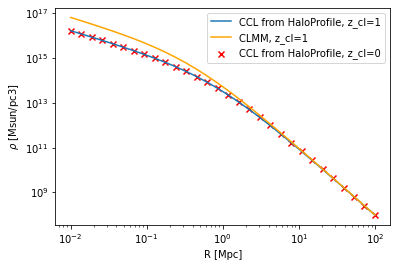

In [16]:
# CLMM result multiplied by h2 to match CCL units
plt.loglog(r_ccl,rho_nfw_ccl_new0, label='CCL from HaloProfile, z_cl=1')
plt.scatter(r_ccl,rho_nfw_ccl_new, label='CCL from HaloProfile, z_cl=0', marker='x', color = 'red')
plt.loglog(r_ccl,rho_nfw_clmm*cosmo['h']*cosmo['h'], label='CLMM, z_cl=1', color='orange')
plt.xlabel('R [Mpc]')
plt.ylabel(r'$\rho$ [Msun/pc3]')
plt.legend()